Cargamos librerias necesarias

Inicialmente instalamos la libreria torch y torchvision

In [25]:
#pip install torch torchvision

In [26]:
#pip install -U scikit-image

In [1]:
import os
import glob as gb
import cv2
import torch
from torchvision import datasets, models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from skimage.feature import graycomatrix, graycoprops

In [2]:
if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No se detectaron GPUs")


GPUs disponibles: 1
GPU 0: Tesla P100-PCIE-16GB


Cargamos las diferentes rutas de los archivos a leer

In [3]:
train_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/train/"
test_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/test"
val_path = "/kaggle/input/skin-burn-dataset/skin burn dataset/valid/"

Realizamos la carga de los datos y los llevamos a DataLoader

In [4]:
from PIL import Image

class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(128),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(128),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)  #aqui con shuffle = True le otorgamos aleatoriedad a la carga de las imagenes
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)

In [5]:
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)

['1st degree burn', '2nd degree burn', '3nd degree burn']
['1st degree burn', '2nd degree burn', '3nd degree burn']


<PIL.Image.Image image mode=RGB size=128x128 at 0x7BDBB2B6C160>


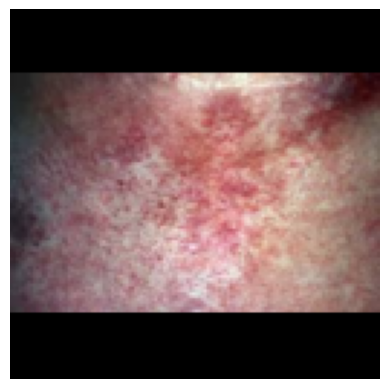

In [17]:
'''
Ahora se debe de conseguir que las imagenes sean todas cuadradas, ya que el resize cambiaba el aspecto de la imagen



utilizar el centro crop
'''

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ruta de la imagen
x = '/kaggle/input/skin-burn-dataset/skin burn dataset/train/2nd degree burn/img1.jpg'

# Cargar la imagen
image = Image.open(x)

# Aplicar la transformación de redimensionamiento
transform = transforms.Resize(size= 127, max_size = 128)
transform2 = transforms.CenterCrop(128)
resized_image = transform2(transform(image))
print(resized_image)

# Mostrar la imagen transformada
plt.imshow(resized_image)
plt.axis('off')  # Opcional: quita los ejes
plt.show()

#solo usar para entrenar el modelo

In [6]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes de entrenamiento
def Show_images(loader):
    plt.figure(figsize=(10, 15))
    for n, (images, labels) in enumerate(loader):
        if n >= 36:
            break
        image = images[0]  # Selecciona la primera imagen del lote
        label = labels[0]  # Selecciona la primera etiqueta del lote
        plt.subplot(6, 6, n + 1)
        image = image.permute(1, 2, 0)  # Reordenar los ejes para mostrar la imagen
        plt.imshow((image * 0.5 + 0.5).numpy())  # Des-normalizar la imagen para mostrarla
        plt.axis('off')
        plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)
    plt.show()

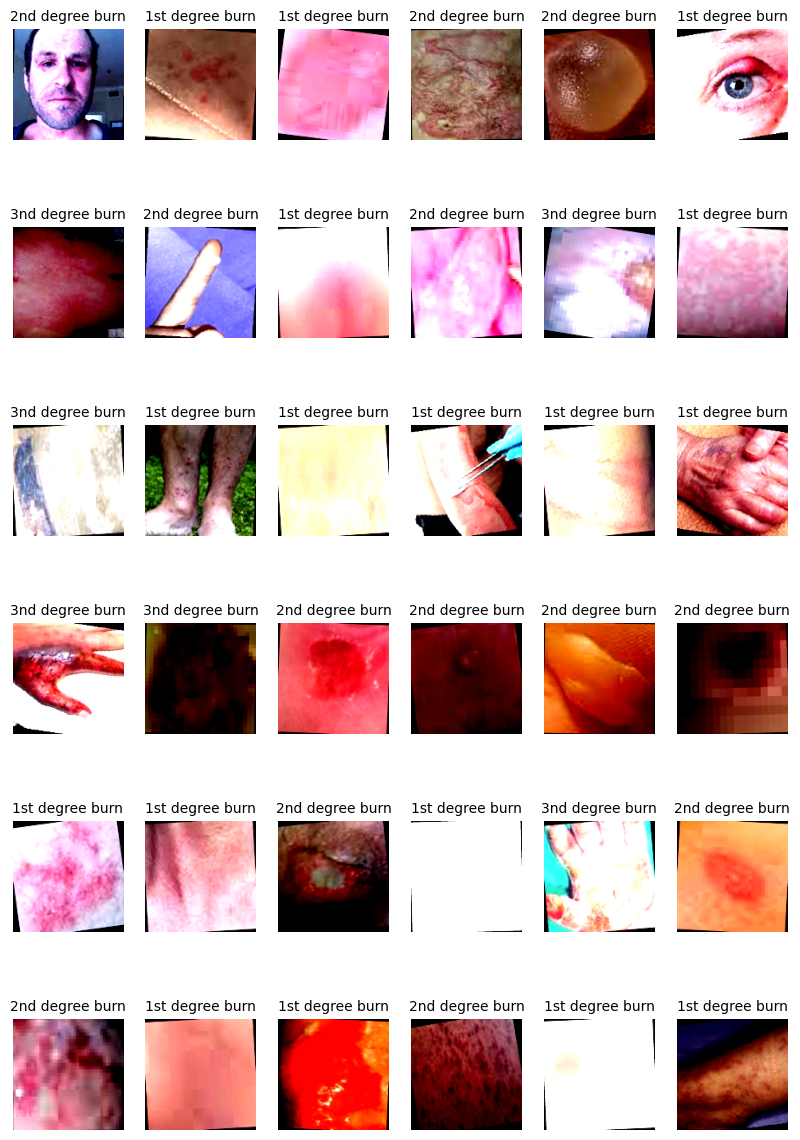

In [7]:
Show_images(train_loader)

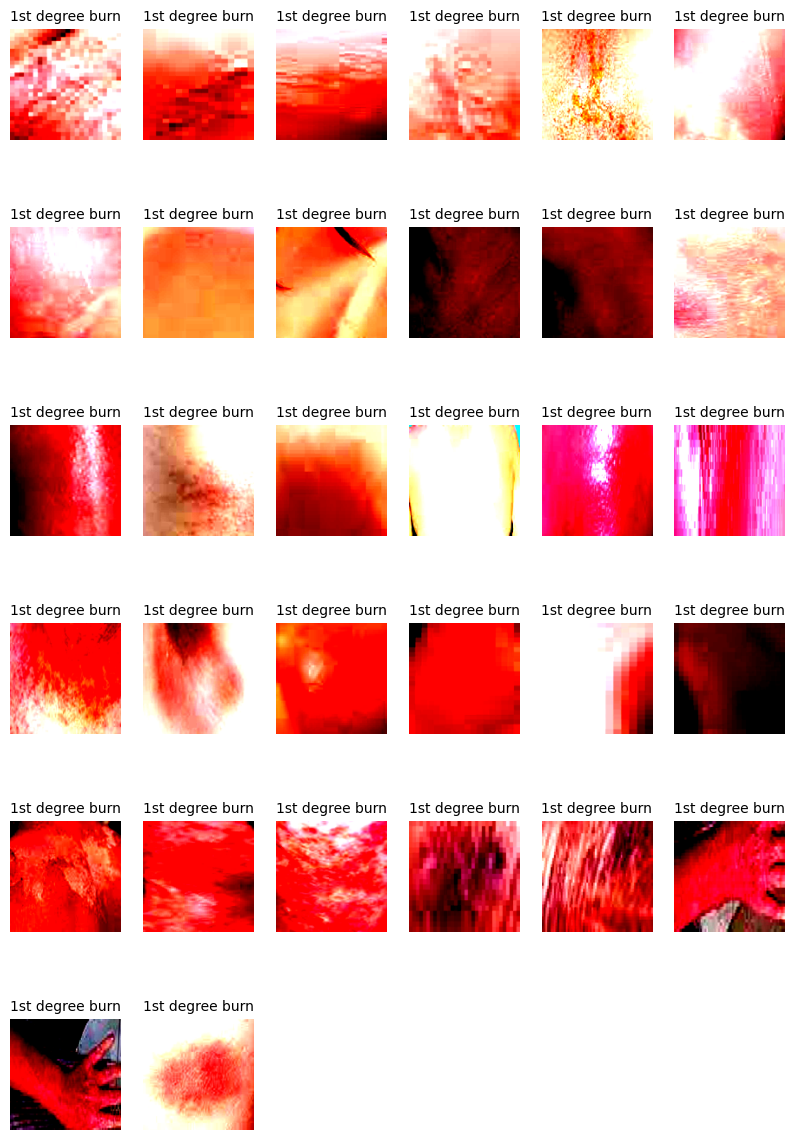

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes del val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Mostrar 36 imágenes del batch
plt.figure(figsize=(10, 15))
for n in range(36):
    if n >= len(images):  # no sobrepasar el número de imágenes en el batch
        break
    image = images[0]  # Selecciona la primera imagen del lote
    label = labels[0]  # Selecciona la primera etiqueta del lote
    plt.subplot(6, 6, n + 1)
    plt.imshow(images[n].permute(1, 2, 0))  # Cambia las dimensiones de [C, H, W] a [H, W, C] para visualizar
    plt.axis('off')
    plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)

plt.show()

Después de que los pesos sean descargados, PyTorch los almacenará en tu caché local, específicamente en el directorio ~/.cache/torch/hub/checkpoints/ 


Así que en ejecuciones futuras, PyTorch cargará los pesos desde esta caché sin necesidad de descargarlos nuevamente.

In [10]:
print(os.listdir("/kaggle/input/resnet18/pytorch/default/1"))

['resnet18-f37072fd.pth']


# ***A continuacion se realizan pruebas con un modelo pre entrenado, es este caso se utiliza ResNet18, 5 folds con 10 epocas c/u***

In [11]:
# 1. Configuración básica del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#Cargar el modelo sin los pesos preentrenados
model = models.resnet18(weights='IMAGENET1K_V1') # Inicializar el modelo

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) 

model = model.to(device)
model_path = '/kaggle/input/resnet18/pytorch/default/1/resnet18-f37072fd.pth'
pretrained_dict = torch.load(model_path)

# Cargar solo los parámetros que coinciden en tamaño (ignorar fc)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# Poner el modelo en modo de evaluación
model.eval()

model = model.to(device)

print("Modelo cargado correctamente desde la ruta:", model_path)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 


Modelo cargado correctamente desde la ruta: /kaggle/input/resnet18/pytorch/default/1/resnet18-f37072fd.pth


In [13]:
from sklearn.metrics import f1_score

In [34]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce el LR cada 5 épocas

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
from torchvision import models

# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0


# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 10
results = {}

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Variable para almacenar la matriz de confusión acumulada
conf_matrix = np.zeros((3, 3))  # Para 3 clases

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    # Redefinir el modelo y optimizador para cada fold
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    
    # Añadir capas adicionales después de la capa fc original
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Primera capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(512, 256),  # Segunda capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(256, 3)  # Capa de salida final para 3 clases
    )
    
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
    
        # Validación y cálculo de matriz de confusión
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

Fold 1/5
Epoch [1/10], Training Loss: 0.9155, Validation Loss: 0.7935, Training Accuracy: 0.5352, Validation Accuracy: 0.6291, Training F1 Score: 0.5104, Validation F1 Score: 0.6250
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.8143, Validation Loss: 0.7559, Training Accuracy: 0.6232, Validation Accuracy: 0.6782, Training F1 Score: 0.6142, Validation F1 Score: 0.6596
Modelo mejorado, guardado.
Epoch [3/10], Training Loss: 0.7899, Validation Loss: 0.7626, Training Accuracy: 0.6295, Validation Accuracy: 0.6609, Training F1 Score: 0.6144, Validation F1 Score: 0.6562
Epoch [4/10], Training Loss: 0.7439, Validation Loss: 0.6759, Training Accuracy: 0.6700, Validation Accuracy: 0.6955, Training F1 Score: 0.6653, Validation F1 Score: 0.6767
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.7298, Validation Loss: 0.7097, Training Accuracy: 0.6875, Validation Accuracy: 0.6791, Training F1 Score: 0.6792, Validation F1 Score: 0.6694
Epoch [6/10], Training Loss: 0.6900, Validati

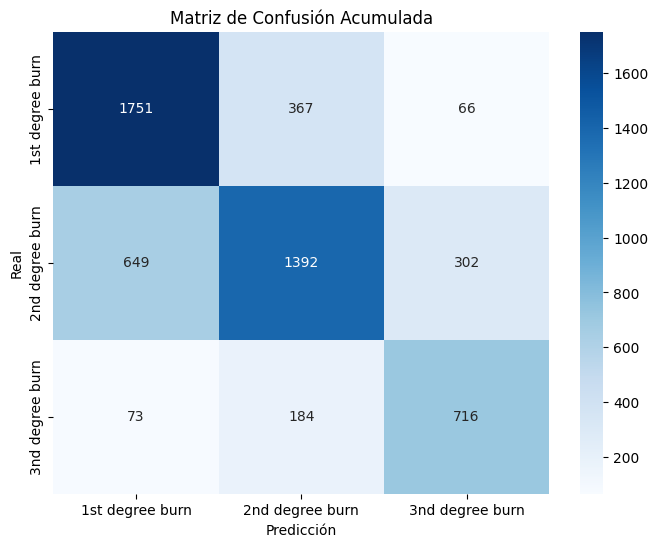

In [22]:
#matriz de confusion
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

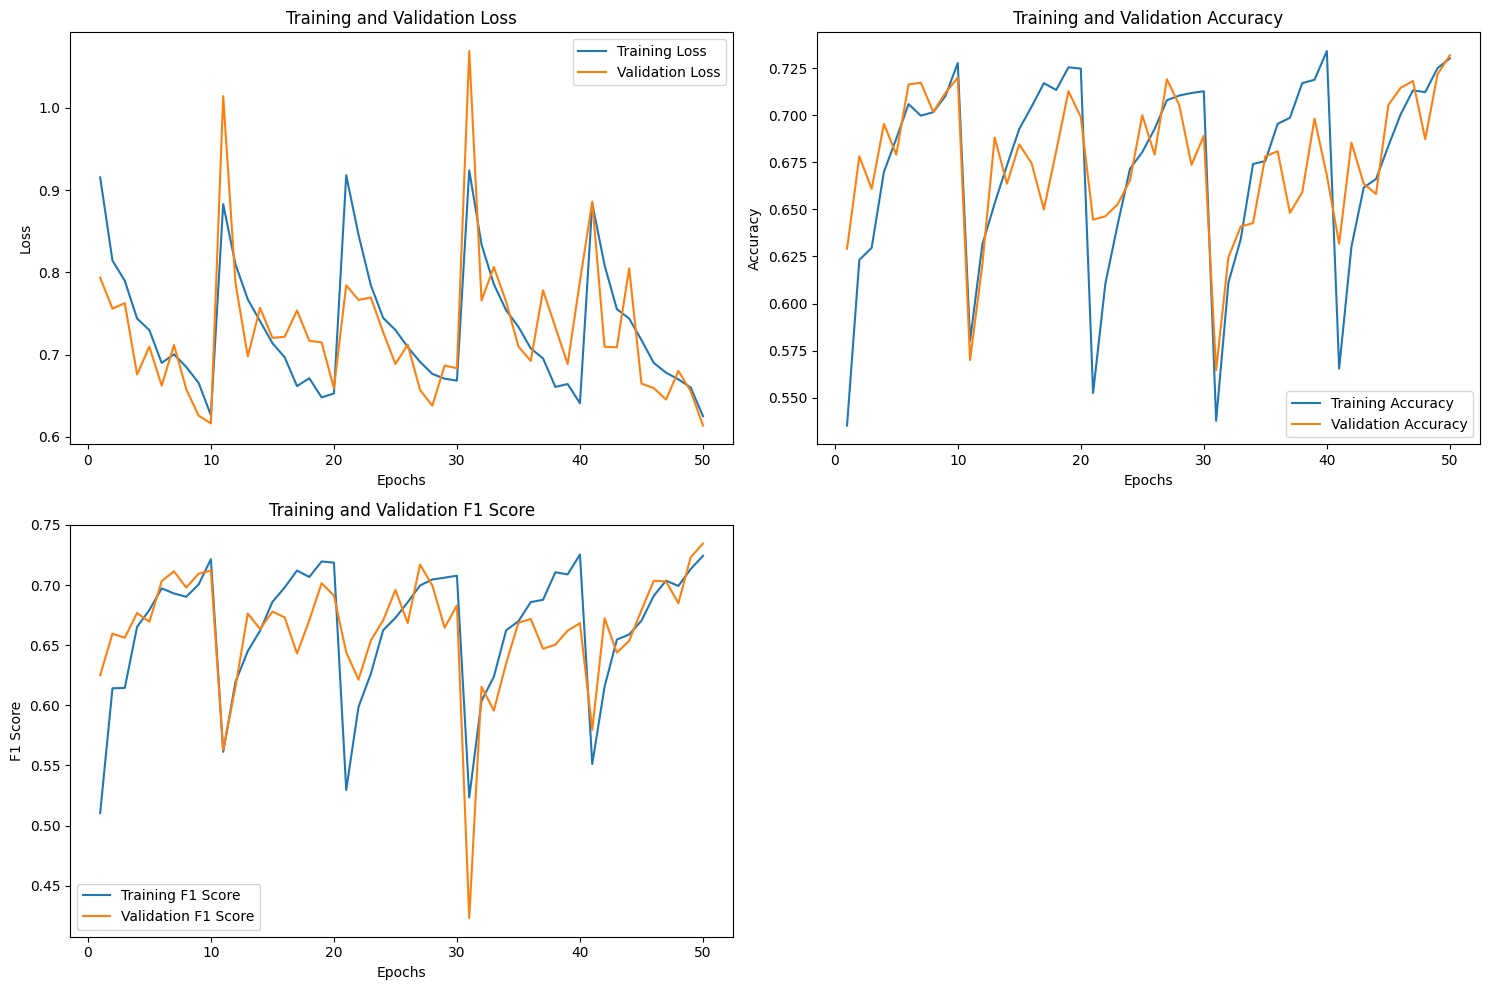

In [25]:
'''
# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
'''

# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# ***A continuacion se realizan pruebas con un modelo pre entrenado, es este caso se utiliza ResNet18, 5 folds con 20 epocas c/u***

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
from torchvision import models

# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, len(class_))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 20
results = {}
conf_matrix = np.zeros((len(class_), len(class_)))

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold in range(k_folds):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    # Redefinir el modelo y optimizador para cada fold
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(512, len(class_))
    model = model.to(device)
    num_ftrs = model.fc.in_features
    
    # Añadir capas adicionales después de la capa fc original
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Primera capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(512, 256),  # Segunda capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(256, 3)  # Capa de salida final para 3 clases
    )
    
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
    
        # Validación y cálculo de matriz de confusión
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fold 1/5
Epoch [1/20], Training Loss: 0.9165, Validation Loss: 1.2257, Training Accuracy: 0.5436, Validation Accuracy: 0.5218, Training F1 Score: 0.5282, Validation F1 Score: 0.4954
Epoch [2/20], Training Loss: 0.8261, Validation Loss: 0.7484, Training Accuracy: 0.6157, Validation Accuracy: 0.6336, Training F1 Score: 0.5974, Validation F1 Score: 0.5378
Epoch [3/20], Training Loss: 0.7921, Validation Loss: 0.8167, Training Accuracy: 0.6450, Validation Accuracy: 0.6027, Training F1 Score: 0.6316, Validation F1 Score: 0.5915
Epoch [4/20], Training Loss: 0.7430, Validation Loss: 0.7317, Training Accuracy: 0.6670, Validation Accuracy: 0.6491, Training F1 Score: 0.6559, Validation F1 Score: 0.6159
Epoch [5/20], Training Loss: 0.7439, Validation Loss: 0.6818, Training Accuracy: 0.6773, Validation Accuracy: 0.6927, Training F1 Score: 0.6644, Validation F1 Score: 0.6827
Epoch [6/20], Training Loss: 0.7221, Validation Loss: 0.6643, Training Accuracy: 0.6750, Validation Accuracy: 0.7091, Training

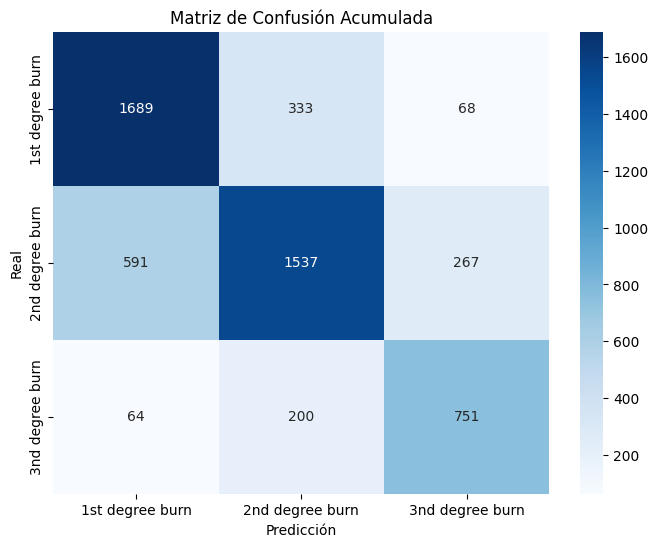

In [29]:
#matriz de confusion
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

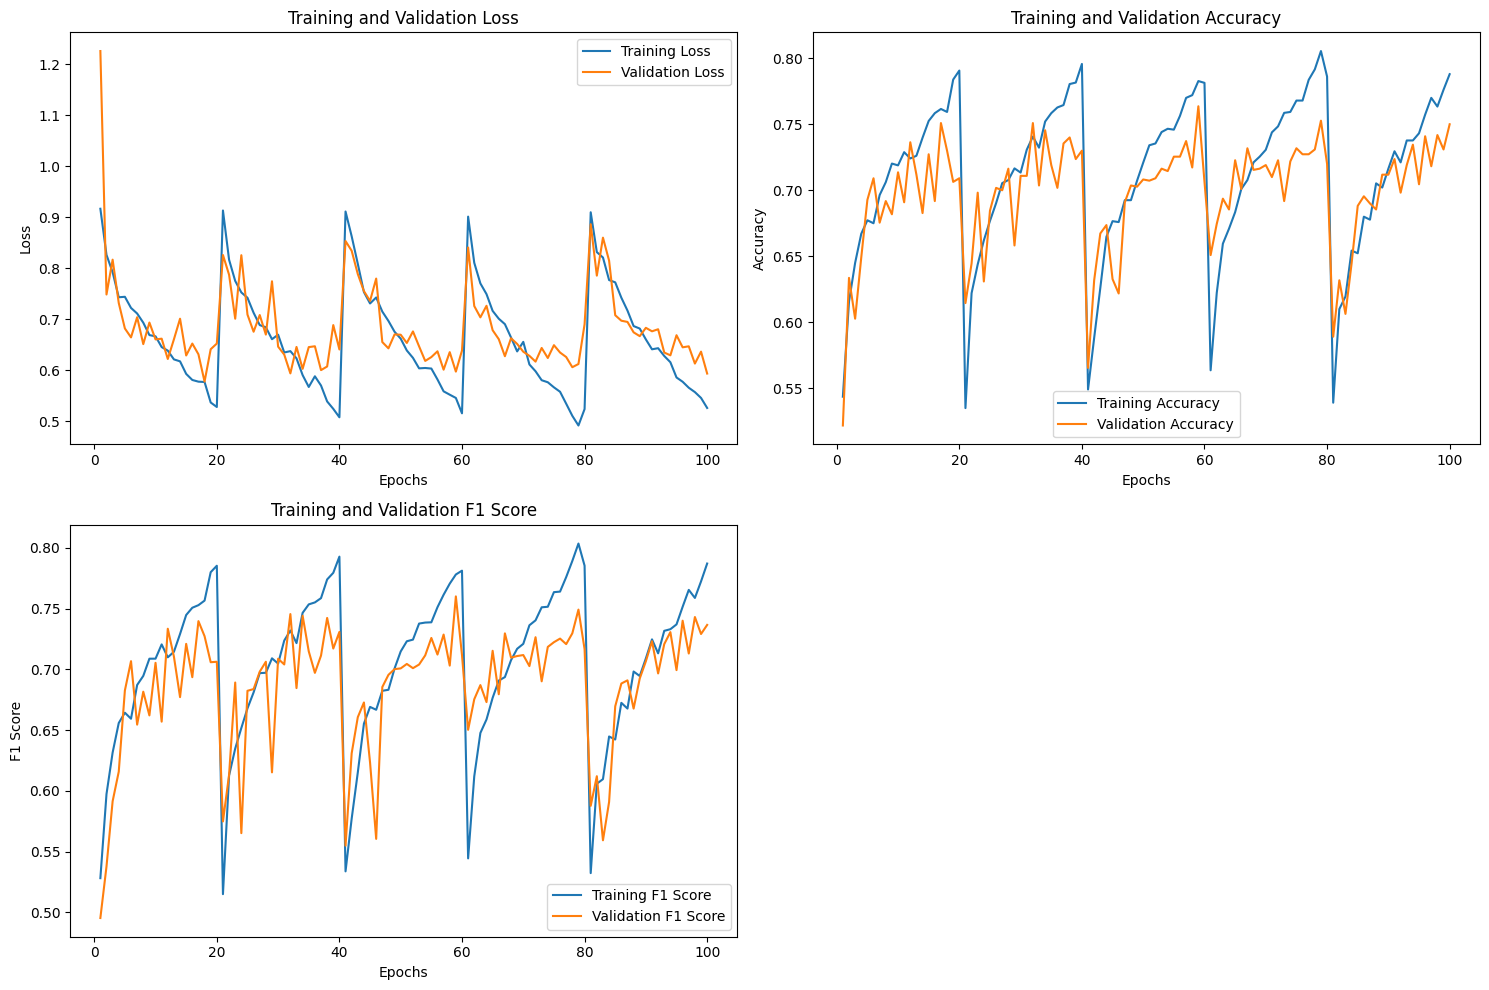

In [30]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

.---

**# A continuación se realizan pruebas con el modelo pre entrenado EficienteNet-64**

In [32]:
# Cargar EfficientNet-B4 sin pesos preentrenados
model = models.efficientnet_b4(weights=None)

# Ajustar la última capa fully connected para 3 clases
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 3)  # Cambiar a 3 clases según tu problema

# Cargar los pesos preentrenados desde el archivo que subiste manualmente
model_path = '/kaggle/input/efficientnet-b4/pytorch/default/1/adv-efficientnet-b4-44fb3a87.pth'  # Cambia la ruta según el archivo subido

# Cargar solo los parámetros que coinciden en tamaño (ignorar fc)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

print("Modelo cargado correctamente desde la ruta:", model_path)

# Mover el modelo a la GPU si está disponible
model = model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

print("Modelo EfficientNet-B4 cargado desde archivo y ajustado para 3 clases.")

Modelo cargado correctamente desde la ruta: /kaggle/input/efficientnet-b4/pytorch/default/1/adv-efficientnet-b4-44fb3a87.pth
Modelo EfficientNet-B4 cargado desde archivo y ajustado para 3 clases.


In [33]:
# Ajustar los hiperparámetros
learning_rate = 0.001  # Learning rate más bajo
weight_decay = 0.001  # Regularización con Weight Decay
num_epochs = 20  # Número de épocas

# Definir optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 20
results = {}
conf_matrix = np.zeros((len(class_), len(class_)))

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold in range(k_folds):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    # Redefinir el modelo y optimizador para cada fold
    model = models.efficientnet_b4(weights=None)
    model.fc = nn.Linear(512, len(class_))
    num_ftrs = model.classifier[1].in_features  # El número de características de salida en EfficientNet-B4 es 1792
    model = model.to(device)
    
    # Añadir capas adicionales después de la capa fc original
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Primera capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(512, 256),  # Segunda capa adicional
        nn.ReLU(),
        nn.Dropout(0.5),  # Regularización
        nn.Linear(256, len(class_))  # Capa de salida final para 3 clases
    )
    
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
    
        # Validación y cálculo de matriz de confusión
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'eficientNet_entrenado.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

Fold 1/5
Epoch [1/20], Training Loss: 1.0285, Validation Loss: 1.0297, Training Accuracy: 0.4436, Validation Accuracy: 0.4373, Training F1 Score: 0.3855, Validation F1 Score: 0.2236
Epoch [2/20], Training Loss: 1.0000, Validation Loss: 0.9502, Training Accuracy: 0.4450, Validation Accuracy: 0.4855, Training F1 Score: 0.3849, Validation F1 Score: 0.3244
Epoch [3/20], Training Loss: 0.9731, Validation Loss: 0.9375, Training Accuracy: 0.4664, Validation Accuracy: 0.4664, Training F1 Score: 0.3980, Validation F1 Score: 0.4553
Epoch [4/20], Training Loss: 0.9407, Validation Loss: 0.9045, Training Accuracy: 0.4918, Validation Accuracy: 0.5273, Training F1 Score: 0.4436, Validation F1 Score: 0.5144
Epoch [5/20], Training Loss: 0.9148, Validation Loss: 0.8953, Training Accuracy: 0.5323, Validation Accuracy: 0.4991, Training F1 Score: 0.4964, Validation F1 Score: 0.4489
Epoch [6/20], Training Loss: 0.8974, Validation Loss: 0.8813, Training Accuracy: 0.5245, Validation Accuracy: 0.5364, Training

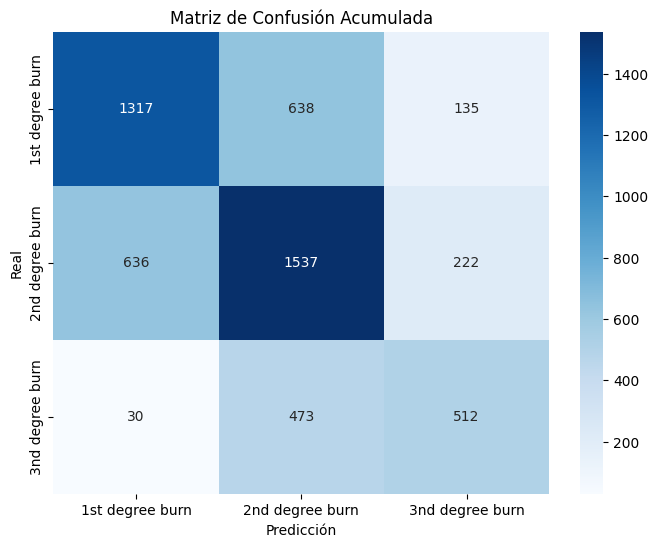

In [34]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

In [35]:
torch.save(model.state_dict(), 'efficientnet_b4_trained.pth')
print("Modelo guardado correctamente.")

Modelo guardado correctamente.


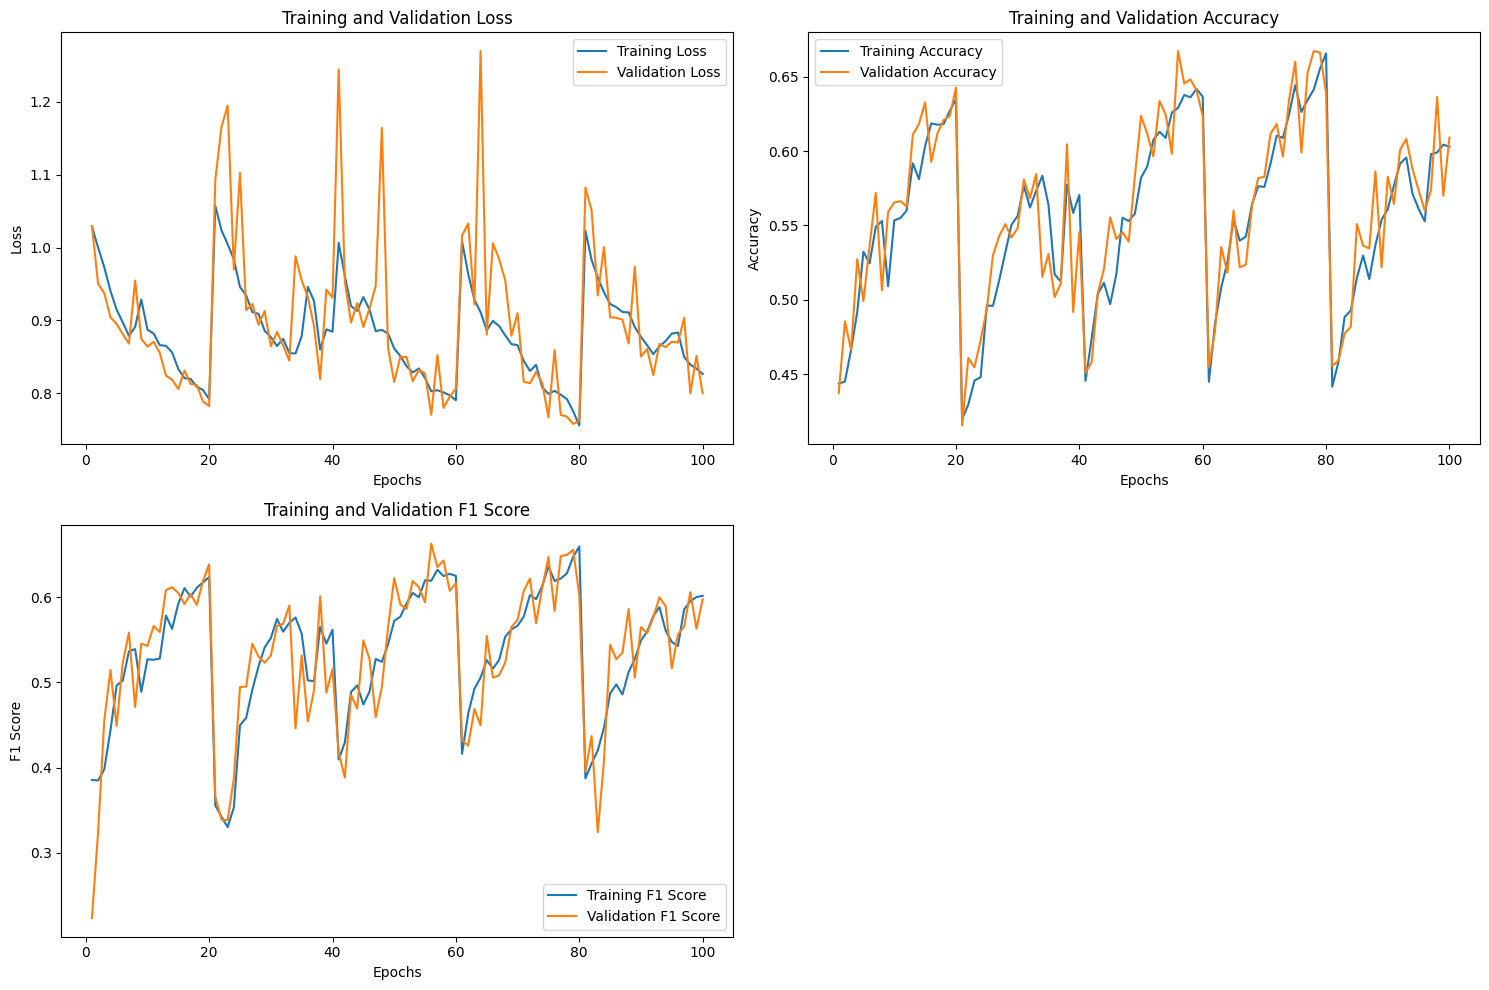

In [36]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# **Prueba con modelo VGG16**

In [6]:
# Cargar el modelo VGG16 preentrenado
vgg16 = models.vgg16(pretrained=True)

# Modificar la capa de salida para nuestro número de clases
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs,  len(class_))  # Cambiar a 3 clases

# Mover a GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Definir el optimizador y la función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 153MB/s]  


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import numpy as np

class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(128),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(128),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Ajustar los hiperparámetros
learning_rate = 0.001  # Learning rate más bajo
weight_decay = 0.001  # Regularización con Weight Decay
num_epochs = 10  # Número de épocas

# Definir optimizador y función de pérdida
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 10
num_classes = 3
results = {}
conf_matrix = np.zeros((len(class_), len(class_)))

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    best_accuracy = 0.0
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    # Cargar el modelo preentrenado VGG16
    vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
    
    # Modificar la última capa classifier
    num_ftrs = vgg16.classifier[0].in_features

    vgg16.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)  # Capa final para el número de clases
    )
    
    vgg16 = vgg16.to(device)
    
    # Definir el optimizador (solo entrenamos la capa classifier)
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
            
    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
    
        train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(all_preds_train) == np.array(all_labels_train))
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        
        # Validación y cálculo de matriz de confusión
        vgg16.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(vgg16.state_dict(), 'vgg16_entrenado.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

Fold 1/5
Epoch [1/10], Training Loss: 0.8388, Validation Loss: 0.7028, Training Accuracy: 0.5841, Validation Accuracy: 0.6845, Training F1 Score: 0.5630, Validation F1 Score: 0.6744
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.7152, Validation Loss: 0.6371, Training Accuracy: 0.6750, Validation Accuracy: 0.7027, Training F1 Score: 0.6673, Validation F1 Score: 0.6990
Modelo mejorado, guardado.
Epoch [3/10], Training Loss: 0.6678, Validation Loss: 0.6255, Training Accuracy: 0.7064, Validation Accuracy: 0.7400, Training F1 Score: 0.7053, Validation F1 Score: 0.7408
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.6424, Validation Loss: 0.6034, Training Accuracy: 0.7166, Validation Accuracy: 0.7400, Training F1 Score: 0.7156, Validation F1 Score: 0.7377
Epoch [5/10], Training Loss: 0.6076, Validation Loss: 0.5824, Training Accuracy: 0.7291, Validation Accuracy: 0.7418, Training F1 Score: 0.7280, Validation F1 Score: 0.7407
Modelo mejorado, guardado.
Epoch [6/10], Trai

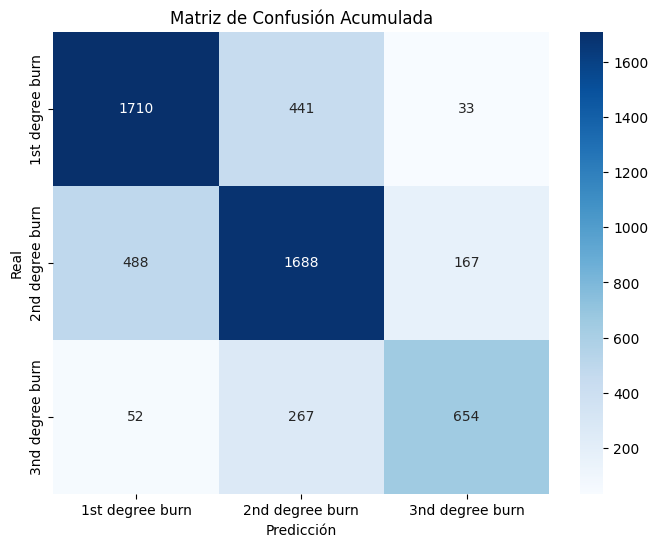

In [15]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

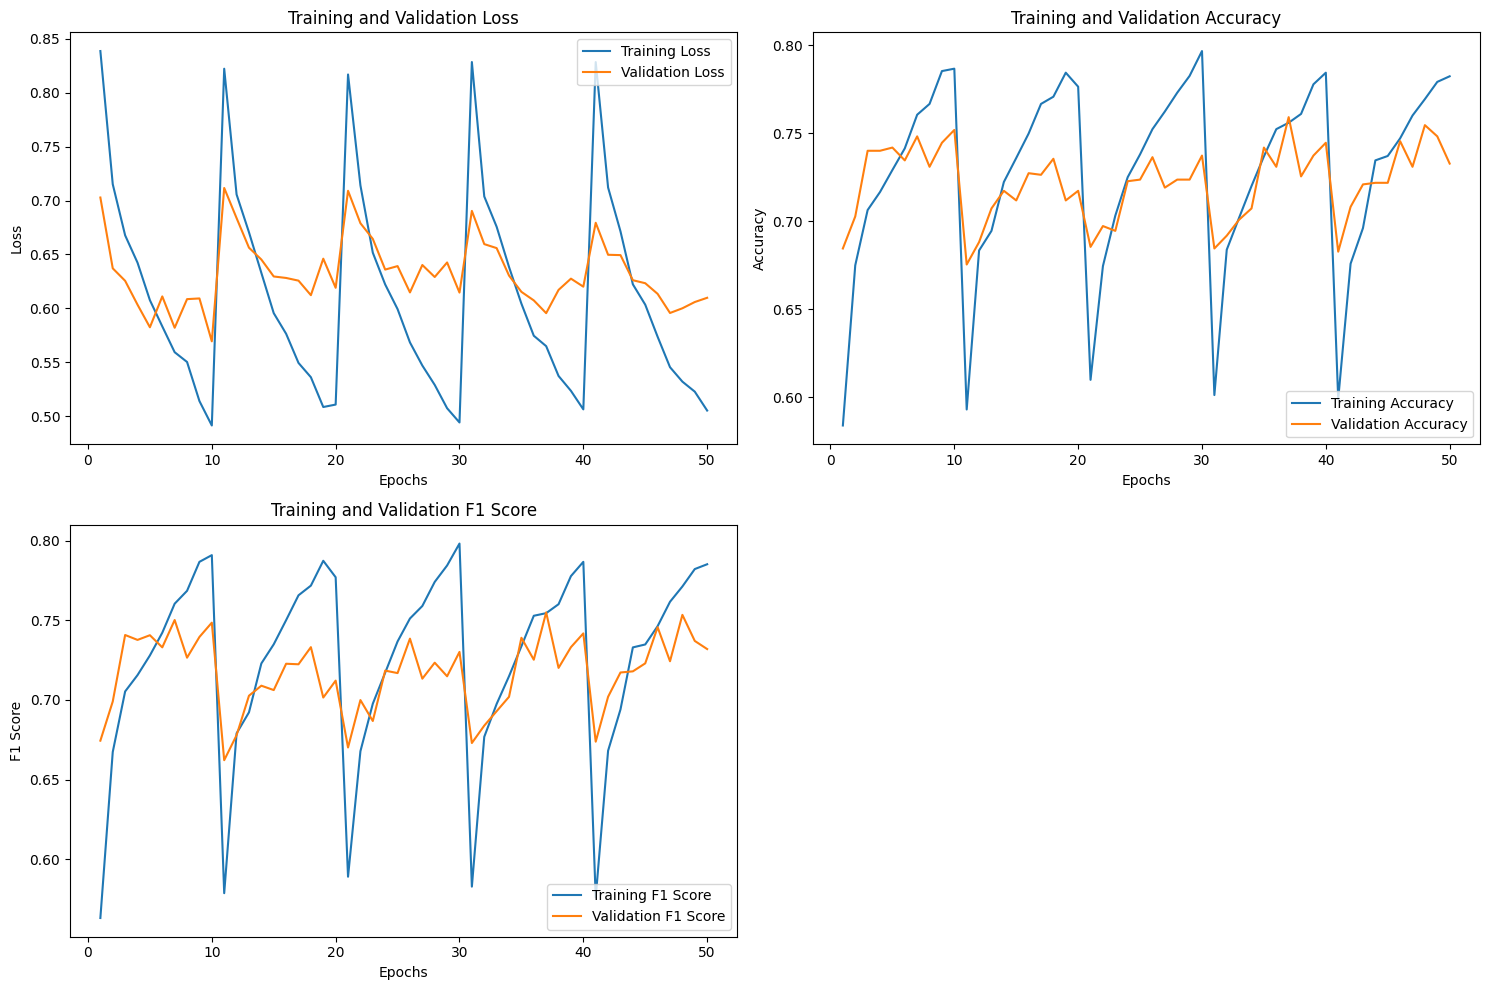

In [16]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# *Probamos con mas epocas por fold***

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variabilidad en el color
    transforms.Resize(128),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(128),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


# En las transformaciones de validación quitamos las alteraciones aleatorias
val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(128),  # Cambiamos el tamaño al valor más pequeño
    transforms.CenterCrop(128),  # Recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)  #aqui con shuffle = True le otorgamos aleatoriedad a la carga de las imagenes
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)

# Ajustar los hiperparámetros
learning_rate = 0.001  # Learning rate más bajo
weight_decay = 1e-4 # Regularización con Weight Decay

# Descongelar más capas
for param in vgg16.features[-4:].parameters():  # Últimas 4 capas convolucionales
    param.requires_grad = True

train_labels = [label for _, label in train_dataset]

# Definir optimizador y función de pérdida
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 20
num_classes = 3
results = {}
conf_matrix = np.zeros((len(class_), len(class_)))

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    best_accuracy = 0.0
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_subsampler)
    
    # Cargar el modelo preentrenado VGG16
    vgg16 = models.vgg16(pretrained = True)

    # Freeze all layers except the last few
    for param in vgg16.features.parameters():
       param.requires_grad = False
    
    # Modificar la última capa classifier
    num_ftrs = vgg16.classifier[0].in_features

    vgg16.classifier = nn.Sequential(
       nn.Linear(num_ftrs, 1024),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(1024, 512),
       nn.ReLU(),
       nn.Dropout(0.5),
       nn.Linear(512, num_classes)
   )
    
    vgg16 = vgg16.to(device)
    
    # Definir el optimizador (solo entrenamos la capa classifier)
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

    # Definir la función de pérdida (con pesos de clases si es necesario)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
            
    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
    
        train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(all_preds_train) == np.array(all_labels_train))
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        
        # Validación y cálculo de matriz de confusión
        vgg16.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        scheduler.step(val_loss)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(vgg16.state_dict(), 'vgg16_entrenado.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

Fold 1/5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 171MB/s]  


Epoch [1/20], Training Loss: 0.8853, Validation Loss: 0.8264, Training Accuracy: 0.5450, Validation Accuracy: 0.5773, Training F1 Score: 0.5396, Validation F1 Score: 0.5747
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.7764, Validation Loss: 0.7474, Training Accuracy: 0.6161, Validation Accuracy: 0.6273, Training F1 Score: 0.6144, Validation F1 Score: 0.6310
Modelo mejorado, guardado.
Epoch [3/20], Training Loss: 0.7466, Validation Loss: 0.7315, Training Accuracy: 0.6318, Validation Accuracy: 0.6555, Training F1 Score: 0.6290, Validation F1 Score: 0.6557
Modelo mejorado, guardado.
Epoch [4/20], Training Loss: 0.7226, Validation Loss: 0.7350, Training Accuracy: 0.6491, Validation Accuracy: 0.6164, Training F1 Score: 0.6491, Validation F1 Score: 0.6184
Epoch [5/20], Training Loss: 0.7005, Validation Loss: 0.7198, Training Accuracy: 0.6689, Validation Accuracy: 0.6427, Training F1 Score: 0.6654, Validation F1 Score: 0.6467
Epoch [6/20], Training Loss: 0.6868, Validation Loss: 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 0.8819, Validation Loss: 0.7668, Training Accuracy: 0.5361, Validation Accuracy: 0.6391, Training F1 Score: 0.5334, Validation F1 Score: 0.6382
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.7930, Validation Loss: 0.7290, Training Accuracy: 0.6000, Validation Accuracy: 0.6282, Training F1 Score: 0.5982, Validation F1 Score: 0.6214
Epoch [3/20], Training Loss: 0.7463, Validation Loss: 0.7206, Training Accuracy: 0.6255, Validation Accuracy: 0.6691, Training F1 Score: 0.6263, Validation F1 Score: 0.6636
Modelo mejorado, guardado.
Epoch [4/20], Training Loss: 0.7198, Validation Loss: 0.7094, Training Accuracy: 0.6452, Validation Accuracy: 0.6536, Training F1 Score: 0.6444, Validation F1 Score: 0.6445
Epoch [5/20], Training Loss: 0.7204, Validation Loss: 0.6938, Training Accuracy: 0.6525, Validation Accuracy: 0.6364, Training F1 Score: 0.6526, Validation F1 Score: 0.6324
Epoch [6/20], Training Loss: 0.6920, Validation Loss: 0.7037, Training Accuracy: 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 0.8970, Validation Loss: 0.7487, Training Accuracy: 0.5334, Validation Accuracy: 0.6591, Training F1 Score: 0.5309, Validation F1 Score: 0.6519
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.7942, Validation Loss: 0.7256, Training Accuracy: 0.6025, Validation Accuracy: 0.6636, Training F1 Score: 0.6008, Validation F1 Score: 0.6609
Modelo mejorado, guardado.
Epoch [3/20], Training Loss: 0.7691, Validation Loss: 0.6953, Training Accuracy: 0.6211, Validation Accuracy: 0.6536, Training F1 Score: 0.6223, Validation F1 Score: 0.6306
Epoch [4/20], Training Loss: 0.7304, Validation Loss: 0.6807, Training Accuracy: 0.6420, Validation Accuracy: 0.6636, Training F1 Score: 0.6436, Validation F1 Score: 0.6507
Epoch [5/20], Training Loss: 0.7261, Validation Loss: 0.6701, Training Accuracy: 0.6359, Validation Accuracy: 0.6800, Training F1 Score: 0.6397, Validation F1 Score: 0.6692
Modelo mejorado, guardado.
Epoch [6/20], Training Loss: 0.7055, Validation Loss: 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 0.8977, Validation Loss: 0.8366, Training Accuracy: 0.5357, Validation Accuracy: 0.5827, Training F1 Score: 0.5347, Validation F1 Score: 0.5798
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.7902, Validation Loss: 0.7254, Training Accuracy: 0.5920, Validation Accuracy: 0.6673, Training F1 Score: 0.5930, Validation F1 Score: 0.6599
Modelo mejorado, guardado.
Epoch 00063: reducing learning rate of group 0 to 1.0000e-06.
Epoch [3/20], Training Loss: 0.7557, Validation Loss: 0.7139, Training Accuracy: 0.6218, Validation Accuracy: 0.6500, Training F1 Score: 0.6216, Validation F1 Score: 0.6442
Epoch [4/20], Training Loss: 0.7432, Validation Loss: 0.6952, Training Accuracy: 0.6314, Validation Accuracy: 0.6491, Training F1 Score: 0.6302, Validation F1 Score: 0.6411
Epoch [5/20], Training Loss: 0.7232, Validation Loss: 0.6801, Training Accuracy: 0.6480, Validation Accuracy: 0.6727, Training F1 Score: 0.6487, Validation F1 Score: 0.6673
Modelo mejorado, gu

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 0.8894, Validation Loss: 0.7608, Training Accuracy: 0.5423, Validation Accuracy: 0.6227, Training F1 Score: 0.5389, Validation F1 Score: 0.6122
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.7877, Validation Loss: 0.7399, Training Accuracy: 0.6023, Validation Accuracy: 0.6345, Training F1 Score: 0.6012, Validation F1 Score: 0.6350
Modelo mejorado, guardado.
Epoch [3/20], Training Loss: 0.7567, Validation Loss: 0.7111, Training Accuracy: 0.6270, Validation Accuracy: 0.6436, Training F1 Score: 0.6265, Validation F1 Score: 0.6349
Modelo mejorado, guardado.
Epoch [4/20], Training Loss: 0.7146, Validation Loss: 0.6708, Training Accuracy: 0.6559, Validation Accuracy: 0.6609, Training F1 Score: 0.6546, Validation F1 Score: 0.6613
Modelo mejorado, guardado.
Epoch 00085: reducing learning rate of group 0 to 1.0000e-08.
Epoch [5/20], Training Loss: 0.7148, Validation Loss: 0.6868, Training Accuracy: 0.6450, Validation Accuracy: 0.6700, Training F1 Score: 0

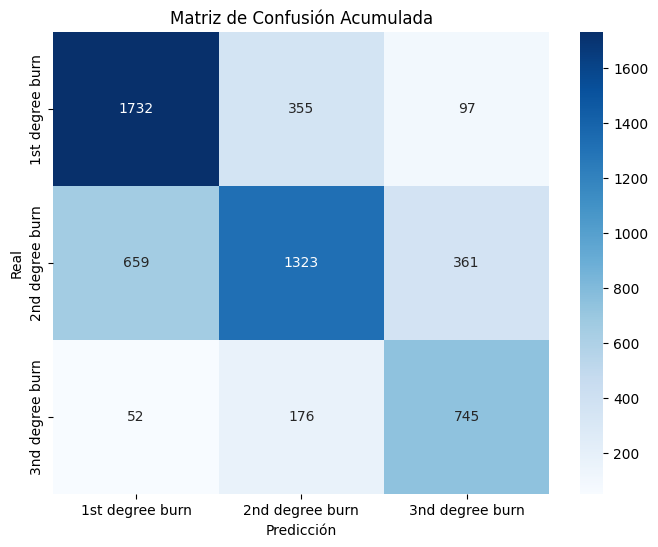

In [10]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

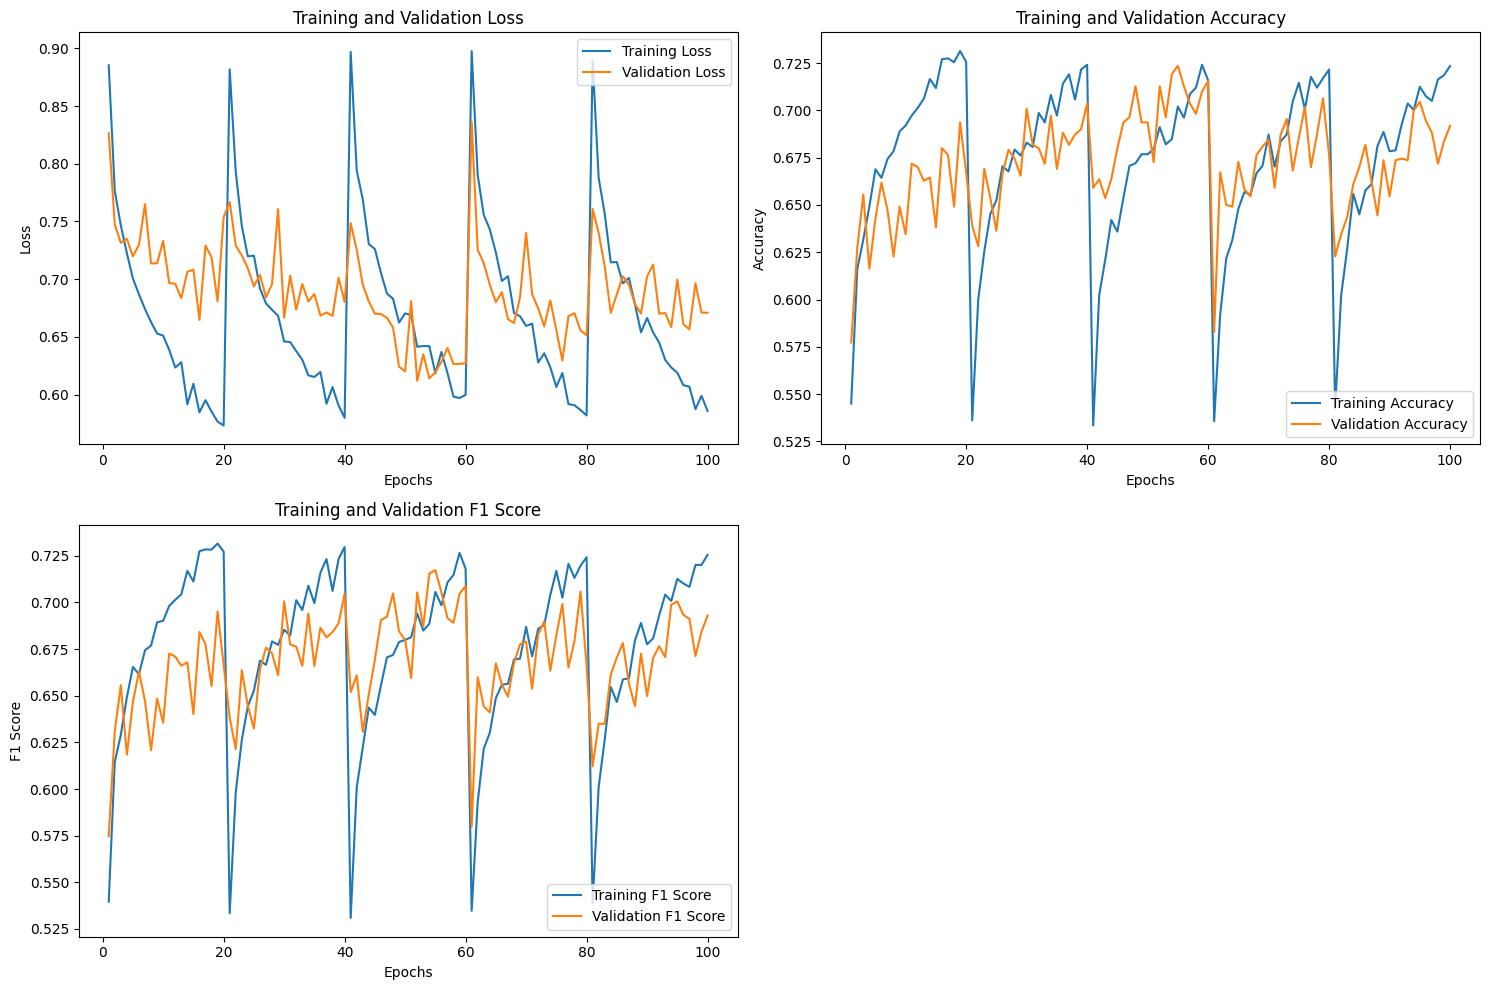

In [11]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()